# **1. Surface Crack Detection 데이터셋**

[Surface Crack Detection 데이터셋](https://www.kaggle.com/datasets/arunrk7/surface-crack-detection)은 콘크리트 표면에서 균열을 자동으로 탐지하기 위한 학습 데이터를 제공합니다. 이 데이터셋은 주로 다양한 콘크리트 표면 이미지를 포함하고 있으며, 각 이미지는 균열이 포함된 부분과 그렇지 않은 부분으로 구분됩니다. 이러한 데이터셋은 컴퓨터 비전 모델, 특히 Convolutional Neural Network(CNN) 등의 딥러닝 모델을 훈련시키는 데 사용되며, 균열 탐지 및 구조물의 상태 평가에 중요한 역할을 합니다. 다양한 환경과 조건을 반영한 이미지를 제공하여, 실제 적용에서 발생할 수 있는 다양한 상황에 대한 모델의 일반화 능력을 높이는 데 도움을 줍니다.

In [ ]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# download via: kaggle cli
!kaggle datasets download arunrk7/surface-crack-detection

Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
License(s): copyright-authors
 53% 123M/233M [00:00<00:00, 1.28GB/s]
100% 233M/233M [00:00<00:00, 797MB/s] 


In [ ]:
!unzip -q surface-crack-detection.zip

In [ ]:
import os
import shutil
import random
import torch
import glob
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# train, val, test 폴더 및 하위 폴더 생성
dataset_structure = ['train/negative', 'train/positive',
                     'val/negative', 'val/positive',
                     'test/negative', 'test/positive']

for folder in dataset_structure:
    os.makedirs(folder, exist_ok=True)



In [ ]:
# 이미지 복사
categories = ['Negative', 'Positive']

for category in categories:
    files = os.listdir(category)  # 이미지 파일을 리스트로 가져옴
    random.shuffle(files)
    num_files = len(files)
    train_split = int(num_files * 0.6)
    val_split = int(num_files * 0.2)

    train_files = files[ :train_split]
    val_files = files[train_split: train_split + val_split]
    test_files = files[train_split + val_split: ]

    target_category = category.lower()

    for file in train_files:
        shutil.copy(os.path.join(category, file), f'train/{target_category}')

    for file in val_files:
        shutil.copy(os.path.join(category, file), f'val/{target_category}')

    for file in test_files:
        shutil.copy(os.path.join(category, file), f'test/{target_category}')

print("데이터 분할 및 복사 완료!")

데이터 분할 및 복사 완료!


In [ ]:
# 폴더 경로 설정 (폴더가 있는 곳을 변수로 만들어 놓음)
train_positive_dir = 'train/positive'
train_negative_dir = 'train/negative'

# 각 폴더에서 4개씩 샘플링
positive_files = random.sample(os.listdir(train_positive_dir), 4)
negative_files = random.sample(os.listdir(train_negative_dir), 4)

print(positive_files)   # 이름만 나옴
print(negative_files)

['18777_1.jpg', '02997.jpg', '07941.jpg', '13618_1.jpg']
['17516.jpg', '18172.jpg', '13749.jpg', '01902.jpg']


In [ ]:
# 파일 경로 리스트 생성
positive_paths = [os.path.join(train_positive_dir, file) for file in positive_files]
negative_paths = [os.path.join(train_negative_dir, file) for file in negative_files]

print(positive_paths)
print(negative_paths)

['train/positive/18777_1.jpg', 'train/positive/02997.jpg', 'train/positive/07941.jpg', 'train/positive/13618_1.jpg']
['train/negative/17516.jpg', 'train/negative/18172.jpg', 'train/negative/13749.jpg', 'train/negative/01902.jpg']


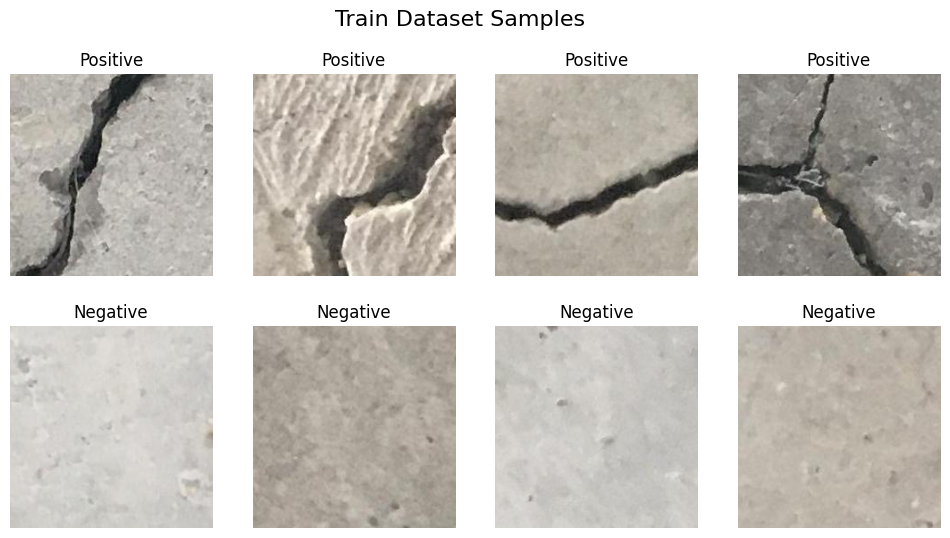

In [ ]:
# 이미지 시각화
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Train Dataset Samples", fontsize=16)

for i, file_path in enumerate(positive_paths):
    image = Image.open(file_path)
    axes[0, i].imshow(image)
    axes[0, i].axis("off")
    axes[0, i].set_title("Positive")

for i, file_path in enumerate(negative_paths):
    image = Image.open(file_path)
    axes[1, i].imshow(image)
    axes[1, i].axis("off")
    axes[1, i].set_title("Negative")
plt.show()

In [ ]:
# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 모두 평균, 표편을 0.5로 맞춤
])

In [ ]:
train_dataset = ImageFolder('/content/train', transform = transform)
val_dataset = ImageFolder('/content/val', transform = transform)

In [ ]:
# 전체 데이터셋 크기 확인
len(train_dataset), len(val_dataset)

(24000, 8000)

In [ ]:
# 사용할 데이터셋의 비율 (예: 10%만 사용)
subset_ratio = 0.1

# 전체 데이터셋 크기 확인
total_train_size = len(train_dataset)
total_val_size = len(val_dataset)

# 선택할 샘플 수 계산
train_subset_size = int(total_train_size * subset_ratio)
val_subset_size = int(total_val_size * subset_ratio)

# 랜덤하게 샘플 선택
train_indices = np.random.choice(total_train_size, train_subset_size, replace=False)  # 변형해서 저장하지 않고, 새롭게 저장함.
val_indeices = np.random.choice(total_val_size, val_subset_size, replace=False)

# Subset을 사용하여 데이터셋 크기 줄이기
# 기존 데이터셋에서 일부 샘플만 골라서 새로운 데이터셋을 만드는 클래스
train_dataset = Subset(train_dataset, train_indices)  # 원하는 크기의 데이터셋 생성 (train_dataset: 원래의 데이터셋, train_indices의 인덱스만 뽑아서 train_dataset에서 찾아 새롭게 데이터셋을 생성)
val_dataset = Subset(val_dataset, val_indeices)

# 데이터셋 크기 출력
print(f"Train dataset size after reduction: {len(train_dataset)}")
print(f"Validation dataset size after reduction: {len(val_dataset)}")

Train dataset size after reduction: 2400
Validation dataset size after reduction: 800


In [ ]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)  # 코어가 몇 개 사용할 지 설정
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

- train_dataset: 학습에 사용할 데이터셋 객체. (torch.utils.data.Dataset을 상속받은 형태여야 한다.)

- batch_size=32: 미니배치 크기를 32로 설정. 즉, 한 번에 32개의 데이터를 가져온다.

- shuffle=True: 각 epoch마다 데이터를 섞어서 사용. 일반적으로 학습 성능을 높이기 위해 설정한다.

- num_workers=2: 데이터를 로드할 때 사용할 서브 프로세스 수입니다. 병렬로 데이터를 불러와서 속도를 높일 수 있다. (CPU)

- pin_memory=True: GPU로 데이터를 옮길 때 더 빠르게 복사할 수 있도록, 데이터를 고정된 메모리에 저장한다. CUDA 사용 시 성능 향상에 도움된다.

# **2. vgg19**
VGG19는 2014년 Visual Geometry Group(VGG)에서 개발한 합성곱 신경망(CNN) 모델로, ImageNet 대회(ILSVRC-2014)에서 우수한 성능을 보이며 널리 알려졌습니다. 총 19개 층(16개의 합성곱 층 + 3개의 완전연결 층)으로 구성되었으며, 모든 합성곱 층에서 3x3 필터를 사용하고, 최대 풀링을 통한 다운샘플링을 적용하여 깊은 계층에서도 효과적으로 특징을 학습할 수 있도록 설계되었습니다. VGG19는 깊은 구조를 통해 고해상도 이미지의 복잡한 패턴을 학습하는 데 강점이 있으며, 이미지 분류, 객체 검출, 스타일 트랜스퍼 등 다양한 컴퓨터 비전 작업에서 널리 활용됩니다. [[논문]](https://arxiv.org/pdf/2412.20345)

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FvUP54%2FbtsMiwMBZRS%2FAAAAAAAAAAAAAAAAAAAAAGTQb2N6uYDJabHcpofCo8USqChSWdmP75VVYaMTc5fB%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1753973999%26allow_ip%3D%26allow_referer%3D%26signature%3D38jrw%252B4Ti506NYkNHRE1xdbmhjo%253D' width=600>

In [ ]:
# VGG 모델 로드 및 네트워크 구조 확인
model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)  # 이 모델의 가중치를 사용해야 한다.
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 178MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

classifier: fc레이어 ?


In [ ]:
# 모델의 모든 파라미터를 고정
for param in model.parameters():
    param.requires_grad = False  # 고정..

In [ ]:
# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
model.classifier[6] = nn.Linear(4096, 2)  # classifier의 6번 인덱스에 접근하여 2개로 출력
model.classifier[6].requires_grad = True

In [ ]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(optimizer_name, model, train_loader, val_loader, criterion, num_epoch=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # momentum=0.9: 지난 가중치를 90% 반영해라.
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))  # 평균과 분산을 동시에 넣어준다.
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"지원하지 않는 최적화 알고리즘: {optimizer_name}")


    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        correct= 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            val_accuracy = correct / total * 100
            val_accuracies.append(val_accuracy)
            print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%', flush=True)
            # flush=True : 강제로 출력 버퍼를 비워줌


    return train_losses, val_losses, val_accuracies


파라미터 설명:
```
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
```

- model.parameters(): 학습 대상인 모델의 파라미터를 옵티마이저에 전달.

- lr=0.001: 학습률은 가중치를 얼마나 빠르게 업데이트할지를 결정한다.

- betas=(0.9, 0.999):

    - β₁ = 0.9: 1차 모멘텀 추정값(gradient 평균)의 decay rate

    - β₂ = 0.999: 2차 모멘텀 추정값(gradient 제곱 평균)의 decay rate

    - 이 두 값은 Adam이 모멘텀과 RMSProp의 장점을 결합하여 더 안정적인 학습을 하도록 도와준다.





### **언제 Adam과 RAdam을 사용할까?**

Adam: 기본적으로 가장 많이 사용되는 최적화 알고리즘이며, 다양한 모델에서 잘 동작함.
RAdam: 학습 초반에 불안정한 동작을 보이는 경우 (예: 작은 배치 크기, 불안정한 손실 함수)에는 Adam보다 RAdam이 더 좋은 선택.

즉, Adam을 먼저 사용하고, 학습이 불안정하면 RAdam을 고려하는 것이 일반적인 전략입니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FbY9yJy%2FbtsMkrLpG47%2FAAAAAAAAAAAAAAAAAAAAACpx8WT9DCZmnD9uE87hACEpLPZiXt_uOm6W7T-96W6k%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1753973999%26allow_ip%3D%26allow_referer%3D%26signature%3DFzXcjqLzQQB1MxWqmGeUBvb%252F%252BXM%253D' width=600>


In [ ]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', model, train_loader, val_loader, criterion)

[SGD] Epoch 1, Train Loss: 0.138500, Val Loss: 0.092142, Validation Accuracy: 97.88%
[SGD] Epoch 2, Train Loss: 0.105947, Val Loss: 0.074668, Validation Accuracy: 97.88%
[SGD] Epoch 3, Train Loss: 0.094411, Val Loss: 0.064884, Validation Accuracy: 98.25%
[SGD] Epoch 4, Train Loss: 0.093722, Val Loss: 0.058643, Validation Accuracy: 98.62%
[SGD] Epoch 5, Train Loss: 0.078767, Val Loss: 0.054835, Validation Accuracy: 98.50%
[SGD] Epoch 6, Train Loss: 0.075508, Val Loss: 0.051291, Validation Accuracy: 98.75%
[SGD] Epoch 7, Train Loss: 0.076034, Val Loss: 0.048474, Validation Accuracy: 98.75%
[SGD] Epoch 8, Train Loss: 0.069426, Val Loss: 0.047216, Validation Accuracy: 98.62%
[SGD] Epoch 9, Train Loss: 0.071031, Val Loss: 0.045095, Validation Accuracy: 98.75%
[SGD] Epoch 10, Train Loss: 0.072545, Val Loss: 0.043309, Validation Accuracy: 98.62%
[SGD] Epoch 11, Train Loss: 0.067802, Val Loss: 0.041886, Validation Accuracy: 98.62%
[SGD] Epoch 12, Train Loss: 0.064638, Val Loss: 0.040454, Valid

In [ ]:
model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)  # classifier의 6번 인덱스에 접근하여 2개로 출력
model.classifier[6].requires_grad = True

train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.165571, Val Loss: 0.070497, Validation Accuracy: 98.25%
[Adam] Epoch 2, Train Loss: 0.075112, Val Loss: 0.049884, Validation Accuracy: 98.88%
[Adam] Epoch 3, Train Loss: 0.067077, Val Loss: 0.042093, Validation Accuracy: 98.50%
[Adam] Epoch 4, Train Loss: 0.057518, Val Loss: 0.038837, Validation Accuracy: 98.50%
[Adam] Epoch 5, Train Loss: 0.050968, Val Loss: 0.033616, Validation Accuracy: 99.25%
[Adam] Epoch 6, Train Loss: 0.047147, Val Loss: 0.031306, Validation Accuracy: 99.25%
[Adam] Epoch 7, Train Loss: 0.046604, Val Loss: 0.028745, Validation Accuracy: 99.38%
[Adam] Epoch 8, Train Loss: 0.041282, Val Loss: 0.027900, Validation Accuracy: 99.12%
[Adam] Epoch 9, Train Loss: 0.043550, Val Loss: 0.024972, Validation Accuracy: 99.50%
[Adam] Epoch 10, Train Loss: 0.042270, Val Loss: 0.024255, Validation Accuracy: 99.38%
[Adam] Epoch 11, Train Loss: 0.045297, Val Loss: 0.025797, Validation Accuracy: 99.12%
[Adam] Epoch 12, Train Loss: 0.035594, Val Loss: 0.0

In [ ]:
model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 2)  # classifier의 6번 인덱스에 접근하여 2개로 출력
model.classifier[6].requires_grad = True

train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', model, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.517416, Val Loss: 0.315067, Validation Accuracy: 95.75%
[RAdam] Epoch 2, Train Loss: 0.232423, Val Loss: 0.170338, Validation Accuracy: 96.62%
[RAdam] Epoch 3, Train Loss: 0.146022, Val Loss: 0.113736, Validation Accuracy: 97.50%
[RAdam] Epoch 4, Train Loss: 0.115813, Val Loss: 0.087695, Validation Accuracy: 98.38%
[RAdam] Epoch 5, Train Loss: 0.091084, Val Loss: 0.072256, Validation Accuracy: 98.50%
[RAdam] Epoch 6, Train Loss: 0.082239, Val Loss: 0.062224, Validation Accuracy: 98.50%
[RAdam] Epoch 7, Train Loss: 0.073966, Val Loss: 0.056151, Validation Accuracy: 98.50%
[RAdam] Epoch 8, Train Loss: 0.065335, Val Loss: 0.050048, Validation Accuracy: 98.62%
[RAdam] Epoch 9, Train Loss: 0.060154, Val Loss: 0.048168, Validation Accuracy: 98.38%
[RAdam] Epoch 10, Train Loss: 0.061600, Val Loss: 0.041618, Validation Accuracy: 98.62%
[RAdam] Epoch 11, Train Loss: 0.055578, Val Loss: 0.038586, Validation Accuracy: 98.75%
[RAdam] Epoch 12, Train Loss: 0.054537, V

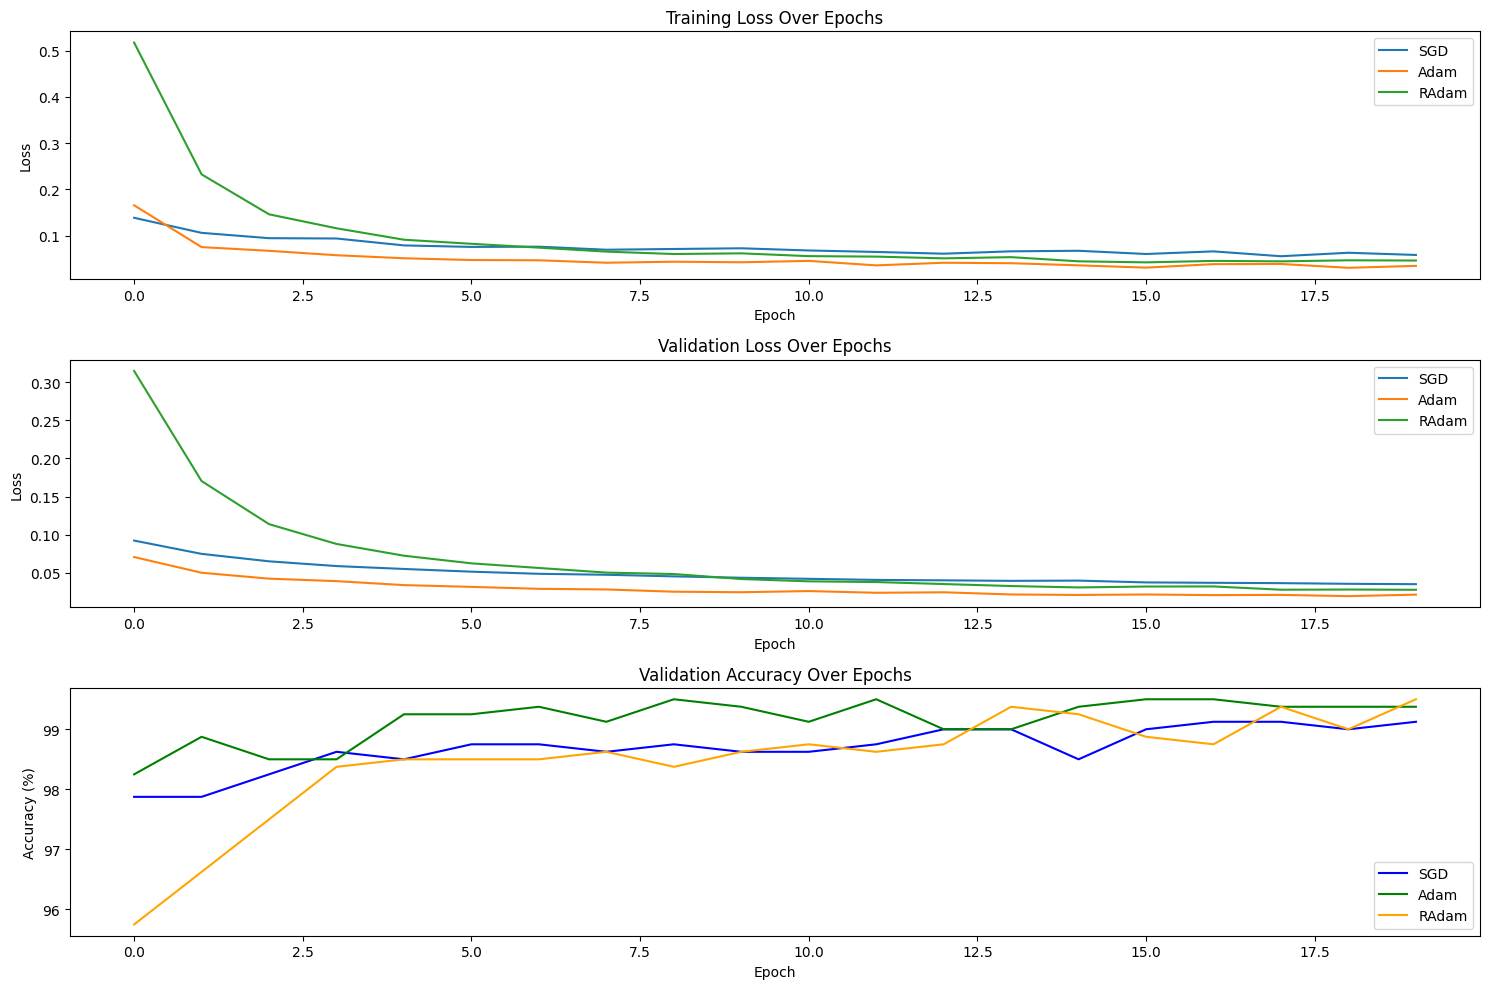

In [ ]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(val_accuracies_RAdam, label='RAdam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

In [ ]:
class_folders = {
    'crack': '/content/test/positive',
    'normal': '/content/test/negative'
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

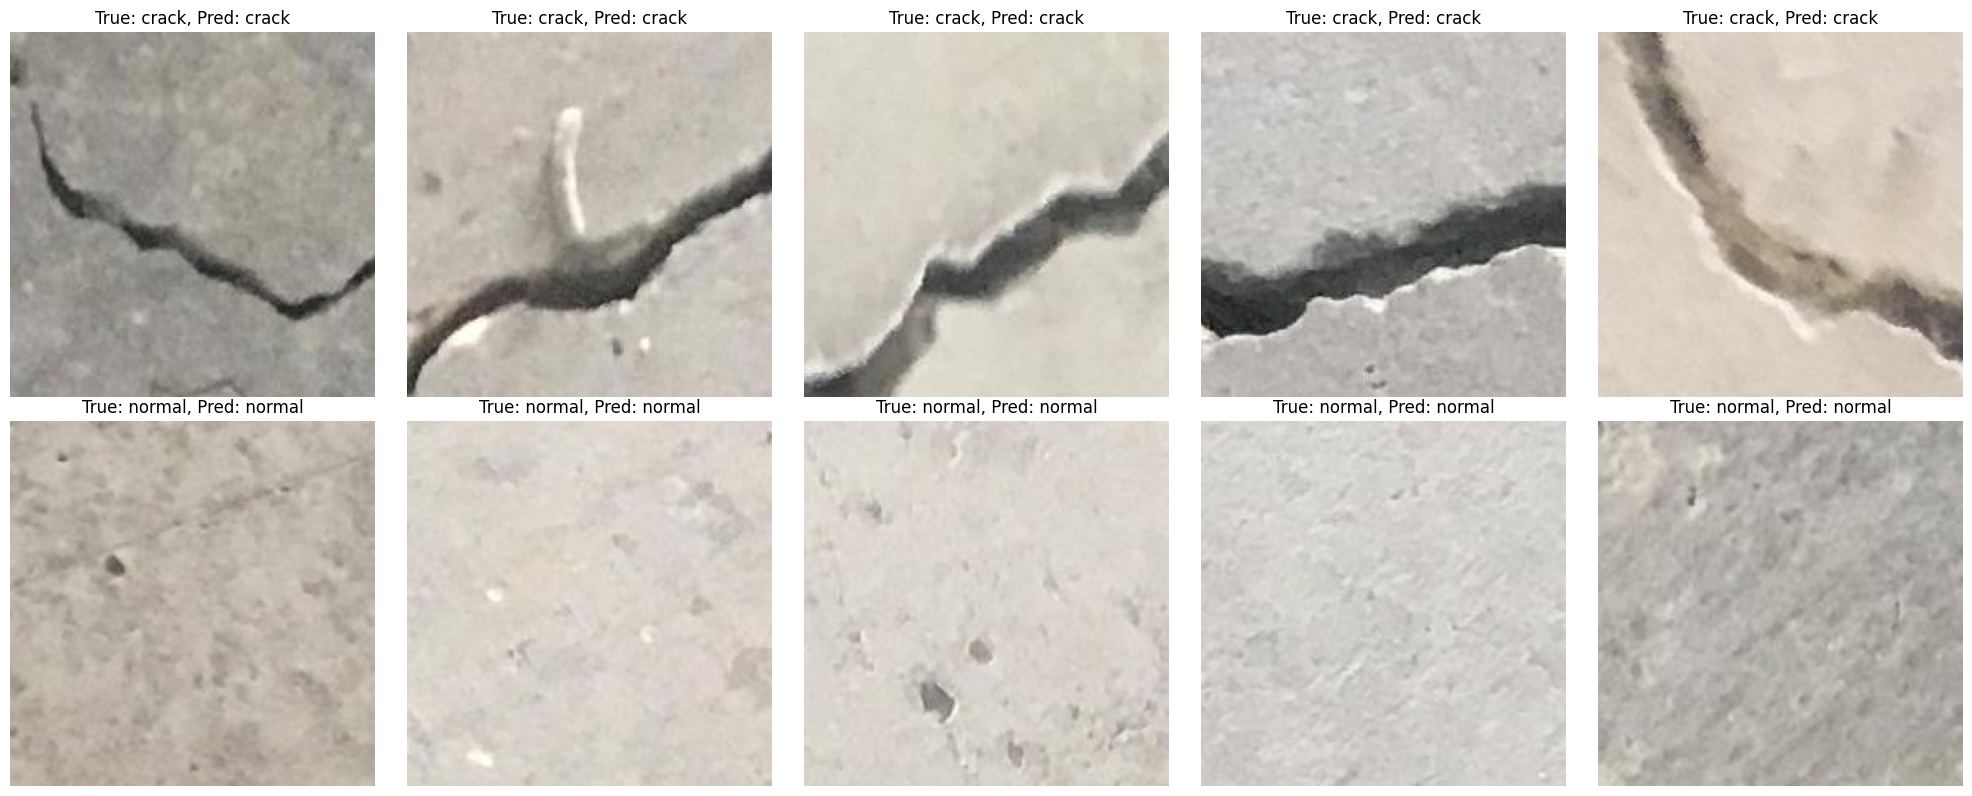

In [ ]:
plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        image = image.to(device)

        model.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'normal' if predicted.item() == 0 else 'crack'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()
